# setup

## magic commands

In [17]:
# "magic" commands, prefaced with "%", changes settings in the notebook

# this ensures plots are embedded in notebook web page
%matplotlib inline

# pdb = Python debugger, so this command turns the debugger OFF
%pdb off

Automatic pdb calling has been turned OFF


## NumPy, SciPy, Matplotlib, SymPy

In [0]:
# numpy = numerical Python, implements arrays (/ matrices)
import numpy as np
# limit number of decimal places printed for floating-point numbers
np.set_printoptions(precision=3)

# scipy = scientific Python, implements operations on arrays / matrices
import scipy as sp
# linalg = linear algebra, implements eigenvalues, matrix inverse, etc
from scipy import linalg as la
# optimize = optimization, root finding, etc
from scipy import optimize as op

# produce matlab-style plots
import matplotlib as mpl
# increase font size on plots
mpl.rc('font',**{'size':18})
# use LaTeX to render symbols
mpl.rc('text',usetex=False)
# animation
from matplotlib import animation as animation
from IPython.display import HTML
mpl.rc('animation', html='jshtml')
# Matlab-style plotting
import matplotlib.pyplot as plt

# symbolic computation, i.e. computer algebra (like Mathematica, Wolfram Alpha)
import sympy as sym


## OS and Colab/Jupyter 

In [0]:
# os = operating system; access OS-level commands
# e.g. create directory, delete file, execute command
# (more platform-independent than "!")
import os

In [20]:
# test whether this is a Colaboratory or Jupyter notebook
try:
  import google.colab
  COLAB = True
  print('Colaboratory Notebook')
except:
  COLAB = False
  print('Jupyter Notebook')

Colaboratory Notebook


In [21]:
# Colab notebook
if COLAB:
  # pip = Python package manager; "!" means "run at system level"
  !pip install slycot
  !pip install control
  
  # render SymPy equations nicely in Colaboratory Notebook
  def colab_latex_printer(exp,**options):
    from google.colab.output._publish import javascript
    url = "https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.3/latest.js?config=default"
    javascript(url=url)
    return sym.printing.latex(exp,**options)
  
  sym.init_printing(use_latex="mathjax",latex_printer=colab_latex_printer)

# Jupyter notebook
else:
  init_printing(use_latex='mathjax')

# Python's Control Systems Toolbox
import control as ctrl

# SciPy module that implements many of the routines in ctrl
from scipy import signal as sig

## helpful functions

In [0]:
def Jacobian(g,y,d=1e-4):
  """
  approximate derivative via finite-central-differences 

  input:
    g - function - g : R^n -> R^m
    y - n array
    (optional)
    d - scalar - finite differences displacement parameter

  output:
    Dg(y) - m x n - approximation of Jacobian of g at y
  """
  # given $g:\mathbb{R}^n\rightarrow\mathbb{R}^m$:
  # $$D_y g(y)e_j \approx \frac{1}{2\delta}(g(y+\delta e_j) - g(y - \delta e_j)),\ \delta\ll 1$$
  e = np.identity(len(y))
  Dyg = []
  for j in range(len(y)):
      Dyg.append((.5/d)*(g(y+d*e[j]) - g(y-d*e[j])))
  return np.array(Dyg).T

def numerical_simulation(f,t,x,t0=0.,dt=1e-4,ut=None,ux=None,utx=None,return_u=False):
  """
  simulate x' = f(x,u) 

  input:
    f : R x X x U --> X - vector field
      X - state space (must be vector space)
      U - control input set
    t - scalar - final simulation time
    x - initial condition; element of X

    (optional:)
    t0 - scalar - initial simulation time
    dt - scalar - stepsize parameter
    return_u - bool - whether to return u_

    (only one of:)
    ut : R --> U
    ux : X --> U
    utx : R x X --> U

  output:
    t_ - N array - time trajectory
    x_ - N x X array - state trajectory
    (if return_u:)
    u_ - N x U array - state trajectory
  """
  t_,x_,u_ = [t0],[x],[]
  
  inputs = sum([1 if u is not None else 0 for u in [ut,ux,utx]])
  assert inputs <= 1, "more than one of ut,ux,utx defined"

  if inputs == 0:
    assert not return_u, "no input supplied"
  else:
    if ut is not None:
      u = lambda t,x : ut(t)
    elif ux is not None:
      u = lambda t,x : ux(x)
    elif utx is not None:
      u = lambda t,x : utx(t,x)

  while t_[-1]+dt < t:
    if inputs == 0:
      _t,_x = t_[-1],x_[-1]
      dx = f(t_[-1],x_[-1]) * dt
    else:
      _t,_x,_u = t_[-1],x_[-1],u(t_[-1],x_[-1])
      dx = f(_t,_x,_u) * dt
      u_.append( _u )

    x_.append( _x + dx )
    t_.append( _t + dt )

  if return_u:
    return np.asarray(t_),np.asarray(x_),np.asarray(u_)
  else:
    return np.asarray(t_),np.asarray(x_)

# quadrotor

Consider the simplified vertical-plane quadrotor model
$$ M\ddot{\eta} = F\sin\theta, $$
$$ M\ddot{\nu} = -Mg + F\cos\theta, $$
$$ I\ddot{\theta} = \tau $$
where ($\eta$, $\nu$) denote the quadrotor (horizontal, vertical) position and $\theta$ denotes the quadrotor's rotation, ($M$, $I$) denote quadrotor (mass, inertia), $g$ is acceleration due to gravity, and ($F$, $\tau$) denote the net (thrust, torque) applied by the spinning rotors.

With $q = (\eta,\nu,\theta)\in\mathbb{R}^3$ denoting positions and $\dot{q} = \frac{d\ }{dt} q = (\dot{\eta},\dot{\nu},\dot{\theta})\in\mathbb{R}^3$ denoting velocities,
the state vector is $x = (q,\dot{q})\in\mathbb{R}^6$,
the input vector is $u = (F,\tau)\in\mathbb{R}^2$,
and the state-space model is
$$ \dot{x} = \frac{d}{dt}\left[\begin{array}{c} q \\ \dot{q} \end{array}\right] = \left[\begin{array}{c} \dot{q} \\ \ddot{q}(x,u) \end{array}\right] = f(x,u), $$
where $\ddot{q} : \mathbb{R}^6 \times \mathbb{R}^2 \rightarrow \mathbb{R}^3$ is defined by 
$$\ddot{q}(x,u) = \left[\begin{array}{c} \frac{F}{M}\sin\theta \\ -g + \frac{F}{M}\cos\theta \\ \frac{\tau}{I}\end{array}\right].$$ 

    [1]: http://dx.doi.org/10.1109/ROBOT.2010.5509452

To simulate the pendulum, we first implement Python versions of the ODE control system model; it'll be computationally expedient if both $f$ and $h$ accept $t$, $x$, and $u$ as arguments even though mathematically they may not depend on all three:

In [0]:
g,M,I = 9.81,1.,1. # m/sec^2, kg, kg m^2

def f(t,x,u):
    q,dq = x[:3],x[3:] # positions, velocities
    eta,nu,theta = q # horiz., vert., rotation
    F,tau = u # thrust, torque
    return np.hstack([dq,(F/M)*np.sin(theta),
                        -g + (F/M)*np.cos(theta),
                        tau/I])

Note that $\dot{q}_0 = 0$ (i.e. zero velocity) is an equilibrium with any position $q$ when input $u = (Mg,0)$ (i.e. zero torque and thrust $Mg$) is applied:

In [24]:
q0 = np.array([0.,1.,0.])
dq0 = np.array([0.,0.,0.])
x0 = np.hstack((q0,dq0))
u0 = np.array([M*g,0.])
print('x0 =',x0,'\nf(x0) =',f(0.,x0,u0))

x0 = [0. 1. 0. 0. 0. 0.] 
f(x0) = [0. 0. 0. 0. 0. 0.]


Let's simulate the result of applying a sinusoidal thrust, and plot/animate the result:

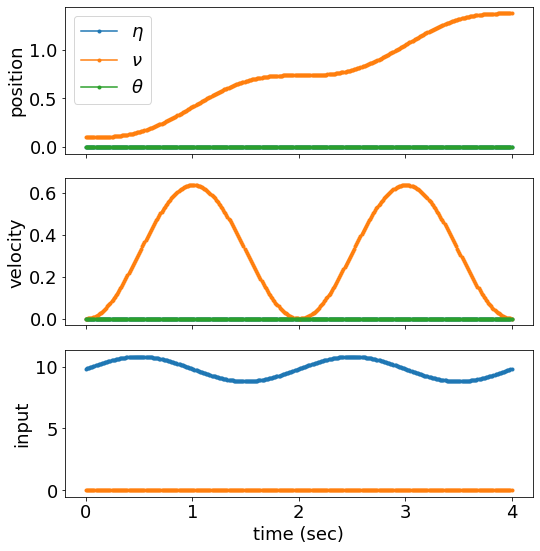

In [25]:
dt = 1e-2 # coarse timestep
freq = .5 # one cycle every two seconds
t = 2./freq # two periods
q = [0.,.1,0.] # start 10cm up off the ground
dq = [0.,0.,0.] # start with zero velocity
x = np.hstack((q,dq))

# input is a periodic function of time
ut = lambda t : np.array([M*g + np.sin(2*np.pi*t*freq),0.])
# lambda is a shorthand way to define a function
# -- equivalently:
def u(t):
    return np.array([M*g + np.sin(2*np.pi*t*freq),0.])

sim = numerical_simulation
t_,x_ = sim(f,t,x,dt=dt,ut=ut)
u_ = np.array([u(t) for t in t_])
# sim() returns arrays t_ and x_
# x_[j] is the state of the system (i.e. pos. and vel.) at time t_[j]

fig = plt.figure(figsize=(8,8));

ax = plt.subplot(311)
ax.plot(t_,x_[:,:3],'.-')
ax.set_xticklabels([])
ax.set_ylabel('position')
ax.legend([r'$\eta$',r'$\nu$',r'$\theta$'],ncol=1,loc='upper left')

ax = plt.subplot(312)
ax.plot(t_,x_[:,3:],'.-')
ax.set_xticklabels([])
ax.set_ylabel('velocity')

ax = plt.subplot(313)
ax.plot(t_,u_,'.-')
ax.set_xlabel('time (sec)')
ax.set_ylabel('input')

plt.tight_layout();

In [0]:
fig, ax = plt.subplots(figsize=(6,6)); ax.axis('equal'); ax.grid(True);

line, = ax.plot([], [], 'b', lw=2);

plt.close(fig)

# initialization -- called once
def init():
  gndh,gndv = [-10.,10.,10.,-10.],[0.,0.,-5.,-.5]
  ax.fill(gndh,gndv,'gray')
  line.set_data([], [])
  ax.set_xlim(( -1., 1.))
  ax.set_ylim(( -.15, 2.))
  ax.set_xlabel(r'horiz. pos. $\eta$')
  ax.set_ylabel(r'vert. pos. $\nu$')
  #plt.tight_layout()
  return (line,)

# animation -- called iteratively
def animate(t):
  j = (t_ >= t).nonzero()[0][0]
  h,v,th = x_[j,:3]
  w = .25
  x = np.array([-w/2.,w/2.,np.nan,0.,0.])
  y = np.array([0.,0.,np.nan,0.,+w/3.])
  z = (x + 1.j*y)*np.exp(1.j*th) + (h + 1.j*v)
  line.set_data(z.real, z.imag)
  return (line,)

# call the animator
animation.FuncAnimation(fig, animate, init_func=init, repeat=True,
                      frames=np.arange(0.,t_[-1],.05), interval=50, blit=True)

To stabilize the quadrotor, we'll linearize the DE (i.e. take the derivative of the function $f$):

In [0]:
A = Jacobian(lambda x : f(0.,x,u0),x)
B = Jacobian(lambda u : f(0.,x,u),u0)

print('A =\n',A,'\n','B =\n',B)

A =
 [[0.   0.   0.   1.   0.   0.  ]
 [0.   0.   0.   0.   1.   0.  ]
 [0.   0.   0.   0.   0.   1.  ]
 [0.   0.   9.81 0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.  ]] 
 B =
 [[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [1. 0.]
 [0. 1.]]


In [0]:
K_random = np.random.randn(2,6)

roots = np.array([-1.502+3.62j , -1.502-3.62j , -1.498+0.627j, -1.498-0.627j, -1.5  +1.5j  , -1.5  -1.5j  ])
K_stable = np.asarray(ctrl.place(A,B,roots))

print("closed loop stable with K_random?",
      np.all(la.eigvals(A - np.dot(B,K_random)).real < 0))

print("closed loop stable with K_stable?",
      np.all(la.eigvals(A - np.dot(B,K_stable)).real < 0))

closed loop stable with K_random? False
closed loop stable with K_stable? True


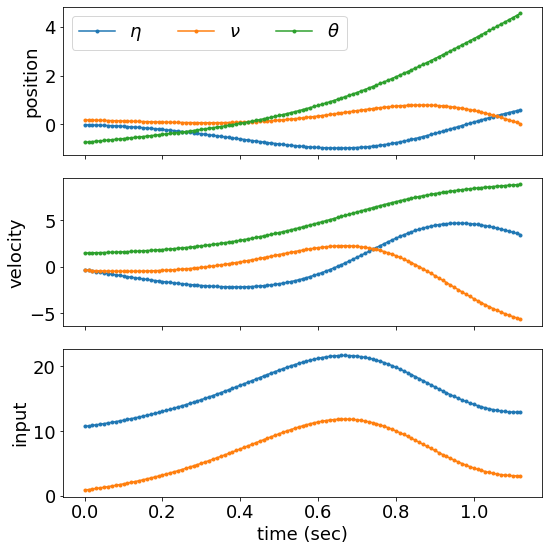

In [0]:
np.random.seed(50)

dt = 1e-2
t = 3. 
x = x0 + 3*(np.random.rand(6)-.5)

# note:  this matrix is actually the wrong size
# in effect, it's acting like a 2 x 6 matrix with repeated row
# I'm keeping it b/c I like the simulation outcome ...
K_random = np.random.randn(6)

# destabilizing controller
K = K_random

# input is now a function of state
ux = lambda x : np.dot(x - x0, -K.T) + u0

t_,x_ = sim(f,t,x,dt=dt,ux=ux)

# quadrotor height
v = x_[:,1]
# if quadrotor crashed
if np.any(v < 0):
  # find when it crashed
  k = np.argmax(v < 0)
  # terminate simulation at crash
  t_ = t_[:k]
  x_ = x_[:k]

u_ = np.array([ux(x) for x in x_])

fig = plt.figure(figsize=(8,8));

ax = plt.subplot(311)
ax.plot(t_,x_[:,:3],'.-')
ax.set_xticklabels([])
ax.set_ylabel('position')
ax.legend([r'$\eta$',r'$\nu$',r'$\theta$'],ncol=3,loc='upper left')

ax = plt.subplot(312)
ax.plot(t_,x_[:,3:],'.-')
ax.set_xticklabels([])
ax.set_ylabel('velocity')

ax = plt.subplot(313)
ax.plot(t_,u_,'.-')
ax.set_xlabel('time (sec)')
ax.set_ylabel('input')

plt.tight_layout();

In [0]:
fig, ax = plt.subplots(figsize=(6,6)); ax.axis('equal'); ax.grid(True);

line, = ax.plot([], [], 'b', lw=2);

plt.close(fig)

# call the animator
animation.FuncAnimation(fig, animate, init_func=init, repeat=True,
                  frames=np.arange(0.,t_[-1],.01), interval=20, blit=True)

Output hidden; open in https://colab.research.google.com to view.

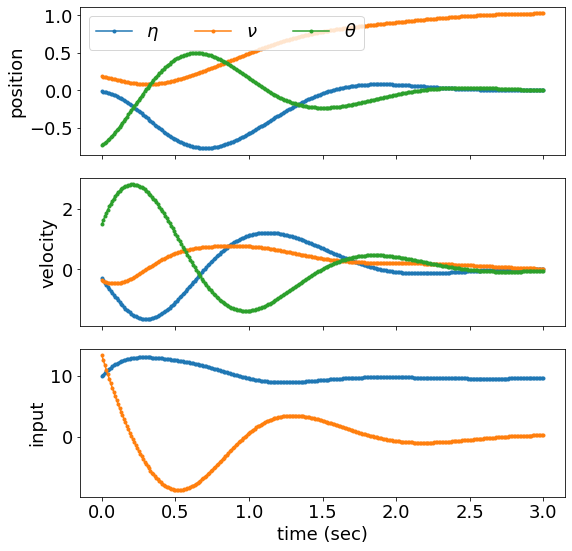

In [0]:
np.random.seed(50)

dt = 1e-2
t = 3. 
x = x0 + 3*(np.random.rand(6)-.5)

# stabilizing controller
K = K_stable

# input is now a function of state
ux = lambda x : np.dot(x - x0, -K.T) + u0

t_,x_ = sim(f,t,x,dt=dt,ux=ux)

# quadrotor height
v = x_[:,1]

u_ = np.array([ux(x) for x in x_])

fig = plt.figure(figsize=(8,8));

ax = plt.subplot(311)
ax.plot(t_,x_[:,:3],'.-')
ax.set_xticklabels([])
ax.set_ylabel('position')
ax.legend([r'$\eta$',r'$\nu$',r'$\theta$'],ncol=3,loc='upper left')

ax = plt.subplot(312)
ax.plot(t_,x_[:,3:],'.-')
ax.set_xticklabels([])
ax.set_ylabel('velocity')

ax = plt.subplot(313)
ax.plot(t_,u_,'.-')
ax.set_xlabel('time (sec)')
ax.set_ylabel('input')

plt.tight_layout();

In [0]:
fig, ax = plt.subplots(figsize=(6,6)); ax.axis('equal'); ax.grid(True);

line, = ax.plot([], [], 'b', lw=2);

plt.close(fig)

# call the animator
animation.FuncAnimation(fig, animate, init_func=init, repeat=True,
                  frames=np.arange(0.,t_[-1],.01), interval=20, blit=True)

Output hidden; open in https://colab.research.google.com to view.